In [ ]:
import os
print(os.getcwd())
os.chdir('experimentation_files')

/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings
data_original = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')

data = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)


In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]

features_temp = [
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]
print(len(features_temp))


target_acc_logres = 'accuracy_logres'


20


In [ ]:
import heapq
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import pandas as pd
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            # Appending 0 if first is greater, otherwise 1
            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result
def bfs_feature_selection(data, features, target, test_size,  models = 0, n_estimators=50, learning_rate=0.1, depth=-1, max_depth_tree=10, max_features='sqrt', max_samples=0.8
                          , includee=[]):
    best_mse = float('inf')
    best_r2 = -1
    best_features = None
    best_model = None
    visited = set()
    evaluation_count = 0

    # Priority queue for Best-First Search
    priority_queue = []

    # Start with the initial combination containing only 'epsilon'
    if len(includee) == 0:
         initial_features = ['epsilon']
    else:
         initial_features = ['epsilon'] + includee
    # initial_features = ['epsilon']
    heapq.heappush(priority_queue, (float('-inf'), initial_features))
    if models ==0:
        print('LightGBM Regressor')
    elif models ==1:
        print('HitsGB Regressor')
    else:
        print('Regular GB Regressor')

    print("Starting BFS feature selection...")

    while priority_queue:
        current_r2, current_features = heapq.heappop(priority_queue)

        current_features_tuple = tuple(sorted(current_features))
        if current_features_tuple in visited:
            continue

        visited.add(current_features_tuple)

        X = data[current_features]
        y = data[target]

        if X.empty or y.empty:
            print(f"Skipping empty data slice for features: {current_features}")
            continue
        # We are using here first 19% for test
        
        split_index = int((test_size) * len(data))
        if split_index % 2 != 0:
            split_index += 1
        X_train, X_test = X.iloc[split_index:], X.iloc[:split_index]
        y_train, y_test = y.iloc[split_index:], y.iloc[:split_index]

        if X_train.empty or y_train.empty:
            print(f"Skipping empty training data for features: {current_features}")
            continue

        if models == 0:
            model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1, max_depth = depth,   n_jobs=2)
        elif models == 1:
            if depth <=-0:
                depth = 1
            model = HistGradientBoostingRegressor(max_iter=n_estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)

        else:
            if depth <=-0:
                depth = 3
            model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, random_state=42
                                         # ,  n_jobs=2
                                             )
        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error fitting model with features: {current_features}, Error: {e}")
            continue

        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Ensure that both y_pred and y_test are even length and perform comparison
        if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
            aa = []
            y_test_2 = y_test.reset_index(drop=True)
            y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
            res_act = comp_func(y_test_2)  
            res_pred = comp_func(y_pred_2)
            for i in range(len(res_act)):
                aa.append(res_act[i] == res_pred[i])

            acc = (aa.count(True) / len(aa)) * 100
        else:
            acc = 0

        evaluation_count += 1

        # Update the best result if r2 improves
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_features = current_features
            best_acc = acc
            best_model = model
            print(f"\nNew best R²: {best_r2:.10f}, MSE: {best_mse:.10f}, Compare Accuracy: {best_acc:.2f}% with features: {best_features}")

        if evaluation_count % 200 == 0:
            print(f"\rEvaluated {evaluation_count} combinations so far...", end='', flush=True)

        # Generate new combinations by adding one more feature to the current set
        for feature in features:
            if feature not in current_features:
                new_features = current_features + [feature]
                # Push -r2 to prioritize higher R² values
                heapq.heappush(priority_queue, (-r2, new_features))

    print("\nBFS complete.")
    print(f"Best feature combination: {best_features}")
    print(f"Best R²: {best_r2:.10f}")
    print(f"Best MSE: {best_mse:.10f}")

    return best_model, best_features, best_mse, best_r2


In [10]:
bfs_feature_selection(data, features_temp, target_acc_logres, 0.19, models = 2,learning_rate = 0.1, n_estimators=100 , 
                      max_features='sqrt', max_samples=0.8)

"""
After 5 minutes
New best R²: 0.4868302454, MSE: 0.0203416939, Compare Accuracy: 93.10% with features: ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation', 'max_categorical_unique', 'skewness', 'num_categorical_attributes']

"""

Regular GB Regressor
Starting BFS feature selection...

New best R²: 0.1628813769, MSE: 0.0331828029, Compare Accuracy: 86.21% with features: ['epsilon']

New best R²: 0.2565669129, MSE: 0.0294691731, Compare Accuracy: 86.21% with features: ['epsilon', 'entropy']

New best R²: 0.3408126458, MSE: 0.0261297305, Compare Accuracy: 86.21% with features: ['epsilon', 'entropy', 'kurtosis']

New best R²: 0.3519644399, MSE: 0.0256876811, Compare Accuracy: 86.21% with features: ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes']

New best R²: 0.4224099141, MSE: 0.0228952713, Compare Accuracy: 96.55% with features: ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation']

New best R²: 0.4269882423, MSE: 0.0227137895, Compare Accuracy: 96.55% with features: ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation', 'max_categorical_unique']

New best R²: 0.4310354552, MSE: 0.0225533608, Compare Accuracy: 96.55% w

KeyboardInterrupt: 

In [ ]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

def our_ml(dataset, test_size, our_features, estimators, learning_rate, depth, target, scalee):
   
    split_index = int(test_size * len(data))
    if split_index % 2 != 0:
        split_index += 1
    X = dataset[list(our_features)]
    y = dataset[target]
    X_train = X.iloc[split_index:]
    X_test = X.iloc[:split_index]

    y_train = y.iloc[split_index:]
    y_test = y.iloc[:split_index]


    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)


    y_pred = gb_model.predict(X_test)
    print('Conditions:')
    print(f'Size: {len(dataset)}')
    print(f'Test size percent is: {test_size}')
    print(f'Attributes: {our_features}')
    print('Actual')
    print(list(y_test))
    print('Prediction')
    print(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Gradient Boosting MSE:", mse)
    print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_

    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        print(aa)
        
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
        print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {acc} %')
        
        print('Prediction vs Actual')
        y_test_2 = list(y_test)
        ll = 0
        mm = 0
        for i in range(len(y_pred)):
            ll += 1
            print(f'{y_pred[i]}  -  {y_test_2[i]}' )
            if ll % 2 == 0:
                print(aa[mm])
                mm += 1
                print('\n')
            ...
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0
        acc = 0


  
    return gb_model, y_pred, y_test_2, importances, mse, r2, acc




Conditions:
Size: 304
Test size percent is: 0.19
Attributes: ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation', 'max_categorical_unique', 'skewness', 'num_categorical_attributes']
Actual
[0.95035461, 0.780141844, 0.7, 0.835, 0.884645062, 0.77507716, 1.0, 0.21749409, 0.899280576, 0.726618705, 0.835931454, 0.745273632, 0.9, 0.846153846, 0.772727273, 0.36722488, 0.871823204, 0.708287293, 0.894504036, 0.650669026, 0.834329349, 0.714475432, 0.837394331, 0.746726338, 0.67, 0.515, 0.6625, 0.8025, 0.783333333, 0.536666667, 0.736, 0.58, 0.95, 0.52, 0.706896552, 0.586206897, 0.966446645, 0.418866887, 0.903, 0.486, 0.95, 0.57, 0.66, 0.575, 0.615, 0.925, 0.705, 0.58, 0.932285714, 0.689571429, 0.84532925, 0.672128637, 0.898153268, 0.727302886, 0.336870027, 0.172413793, 0.263537906, 0.281588448]
Prediction
[0.75449669 0.59998029 0.68202539 0.58693609 0.61585484 0.54435789
 0.66296465 0.50517666 0.85710159 0.59281921 0.822781   0.63596564
 0.69866738 0.6195

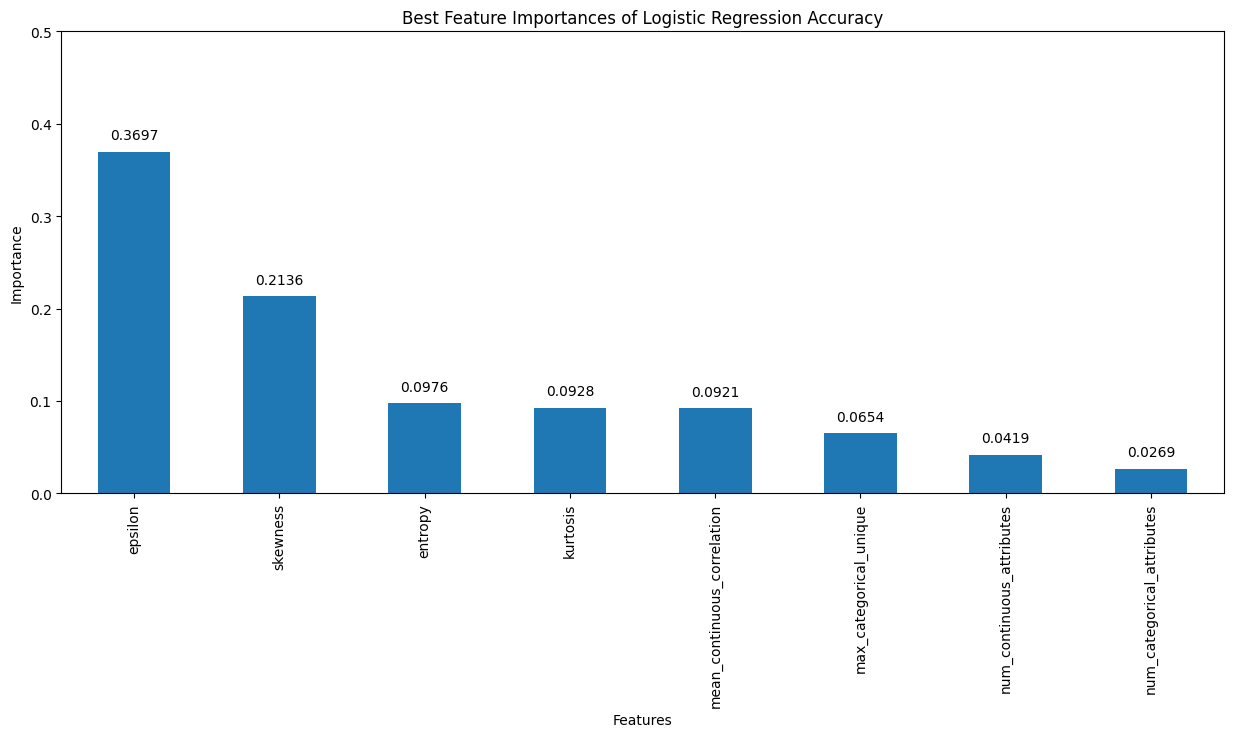

In [ ]:

best_features = ['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation', 'max_categorical_unique', 'skewness', 'num_categorical_attributes']
first_1, best_predictions, best_actual, first_importances, first_mse, first_r2, first_acc  = our_ml(data, 0.19, best_features, 100, 0.1, 3, target_acc_logres, 0)

first_importances_sorted = first_importances.sort_values(ascending=False)
plt.figure(figsize=(15, 6))
plt.ylim(0, 0.5)
ax = first_importances_sorted.plot(kind='bar')
for i, v in enumerate(first_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.title('Best Feature Importances of Logistic Regression Accuracy')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()



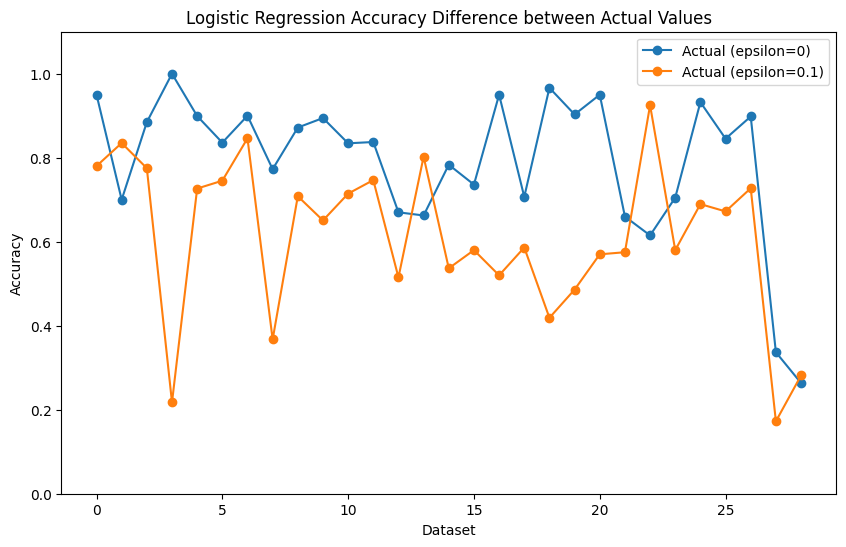

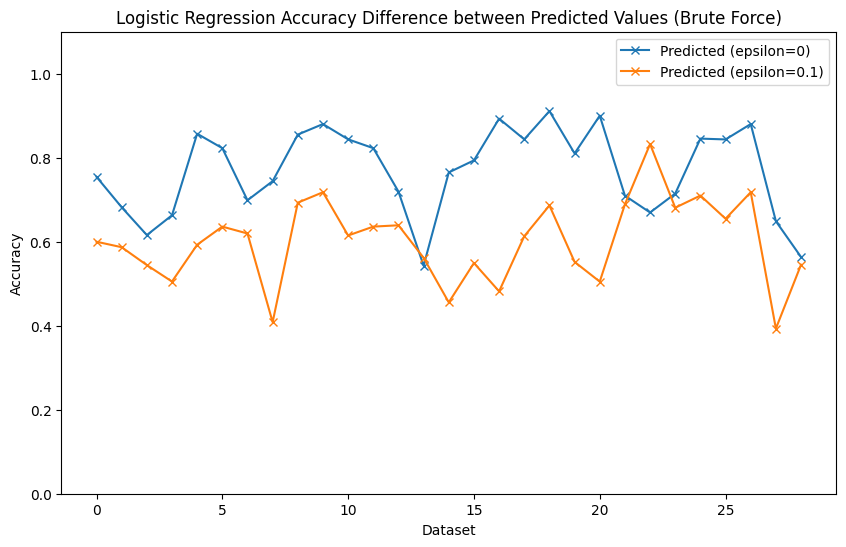

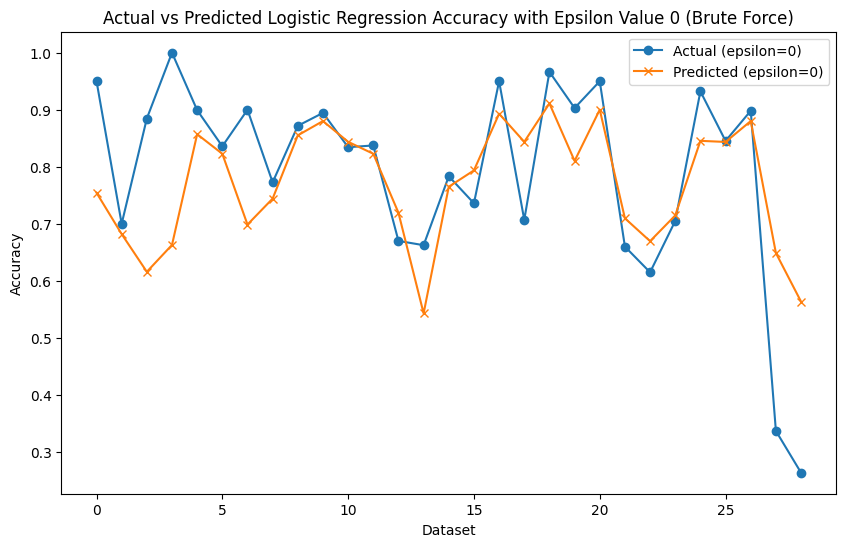

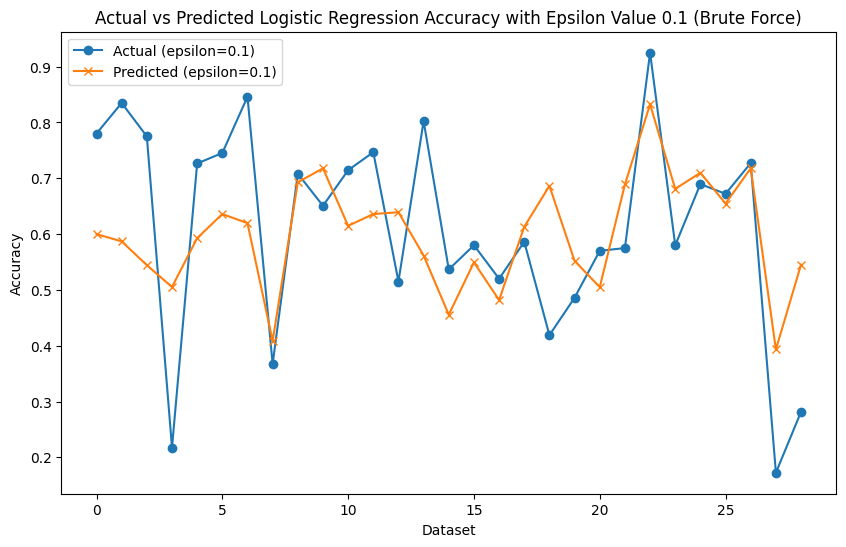

In [ ]:
import matplotlib.pyplot as plt

# Separate the data by epsilon
best_actual_0 = [best_actual[i] for i in range(0, len(best_actual), 2)]   # Actual values for epsilon 0
best_actual_01 = [best_actual[i] for i in range(1, len(best_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [best_predictions[i] for i in range(0, len(best_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [best_predictions[i] for i in range(1, len(best_predictions), 2)] # Predicted values for epsilon 0.1


x_indices_0 = range(len(best_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(best_actual_01))   # Indices for epsilon 0.1
y_min = 0
# y_max = max(max(best_actual_0), max(best_actual_01), max(y_pred_0), max(y_pred_01))
y_max = 1.1

# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)
plt.title('Logistic Regression Accuracy Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('log_res_accuracy_difference_between_actual_values.png') 
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Logistic Regression Accuracy Difference between Predicted Values (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('log_res_brute_accuracy_difference_between_predicted_values.png')  
plt.show()

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.title('Actual vs Predicted Logistic Regression Accuracy with Epsilon Value 0 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('log_res_brute_accuracy_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.title('Actual vs Predicted Logistic Regression Accuracy with Epsilon Value 0.1 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('log_res_brute_accuracy_actual_vs_predicted_epsilon_01.png') 
plt.show()


['epsilon', 'entropy', 'kurtosis', 'num_continuous_attributes', 'mean_continuous_correlation', 'max_categorical_unique', 'skewness', 'num_categorical_attributes']

Importances Sorted
['epsilon', 'skewness', 'entropy', 'kurtosis', 'mean_continuous_correlation', 'max_categorical_unique', 'num_continuous_attributes', 'num_categorical_attributes']
Conditions:
Size: 304
Test size percent is: 0.19
Attributes: ['epsilon', 'skewness', 'entropy', 'kurtosis', 'mean_continuous_correlation', 'max_categorical_unique', 'num_continuous_attributes', 'num_categorical_attributes']
Actual
[0.95035461, 0.780141844, 0.7, 0.835, 0.884645062, 0.77507716, 1.0, 0.21749409, 0.899280576, 0.726618705, 0.835931454, 0.745273632, 0.9, 0.846153846, 0.772727273, 0.36722488, 0.871823204, 0.708287293, 0.894504036, 0.650669026, 0.834329349, 0.714475432, 0.837394331, 0.746726338, 0.67, 0.515, 0.6625, 0.8025, 0.783333333, 0.536666667, 0.736, 0.58, 0.95, 0.52, 0.706896552, 0.586206897, 0.966446645, 0.418866887, 0.903, 0.486

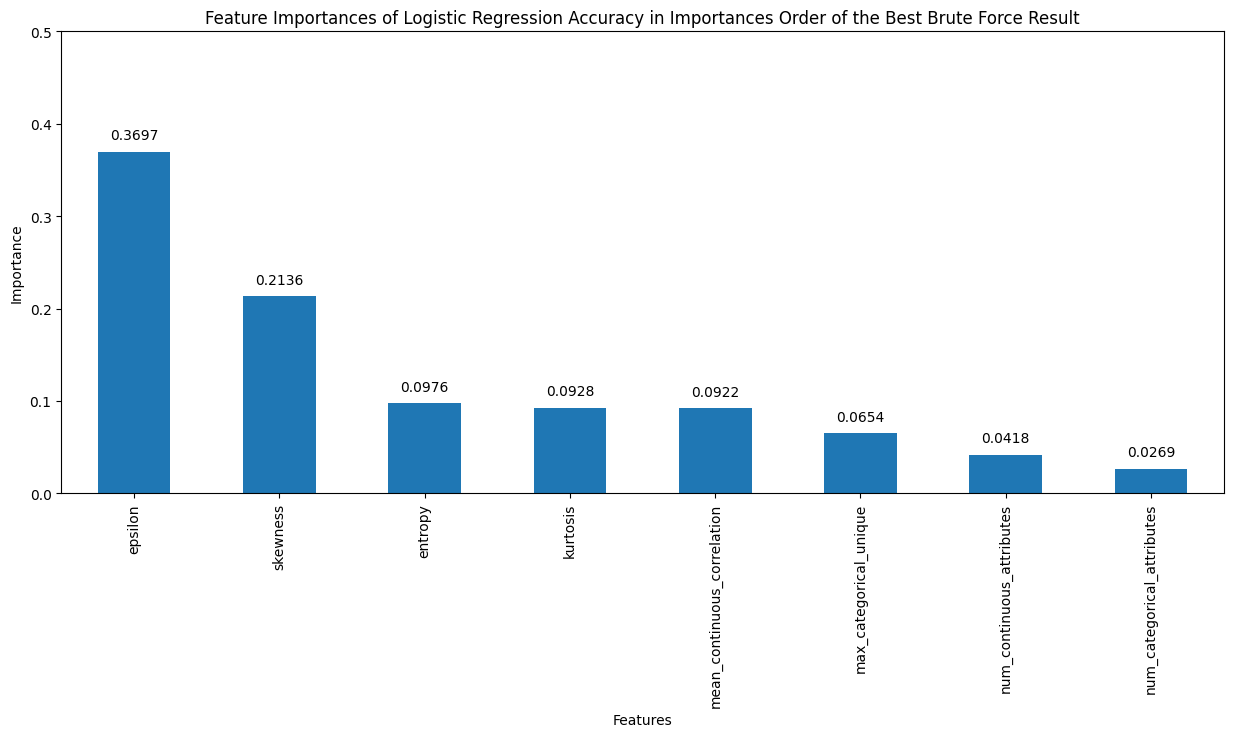

'   \nGradient Boosting MSE: 0.020341693936272873\nGradient Boosting R²: 0.4868302453900383\n[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]\nAccuracy of the comparison which one more consumable/accurate/riskier: 93.10344827586206 %\n\nGradient Boosting MSE: 0.020291580075077094\nGradient Boosting R²: 0.48809449201241706\n[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]\nAccuracy of the comparison which one more consumable/accurate/riskier: 93.10344827586206 %\n'

In [12]:
fffff = first_importances_sorted.index.tolist()
print(best_features)
print('\nImportances Sorted')
print(fffff)
#our_ml(dataset, test_size, our_features, estimators, learning_rate, depth, target, scalee)
ee0, ee1, ee2, ee3_importances, ee4, ee5, ee6  = our_ml(data, 0.19, fffff, 100, 0.1, 3, target_acc_logres, 0)
ee3_importances_sorted = ee3_importances.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
ax = ee3_importances_sorted.plot(kind='bar')
for i, v in enumerate(ee3_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.ylim(0, 0.5)
plt.title('Feature Importances of Logistic Regression Accuracy in Importances Order of the Best Brute Force Result')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()

"""   
Gradient Boosting MSE: 0.020341693936272873
Gradient Boosting R²: 0.4868302453900383
[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]
Accuracy of the comparison which one more consumable/accurate/riskier: 93.10344827586206 %

Gradient Boosting MSE: 0.020291580075077094
Gradient Boosting R²: 0.48809449201241706
[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]
Accuracy of the comparison which one more consumable/accurate/riskier: 93.10344827586206 %
"""